<a href="https://colab.research.google.com/github/Himanshukunar/excelr-assignments/blob/main/Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

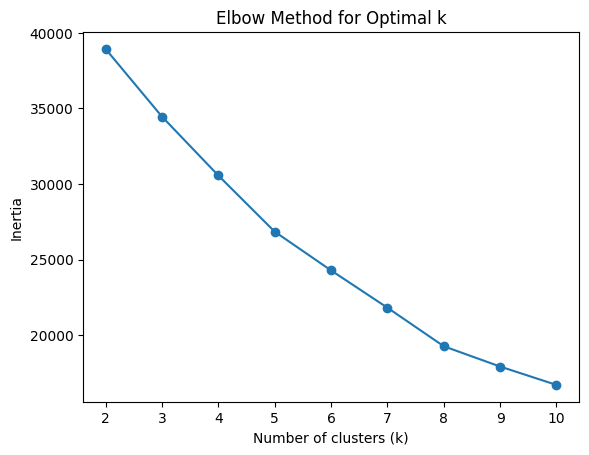

K-Means Silhouette Score: 0.28162505933958065


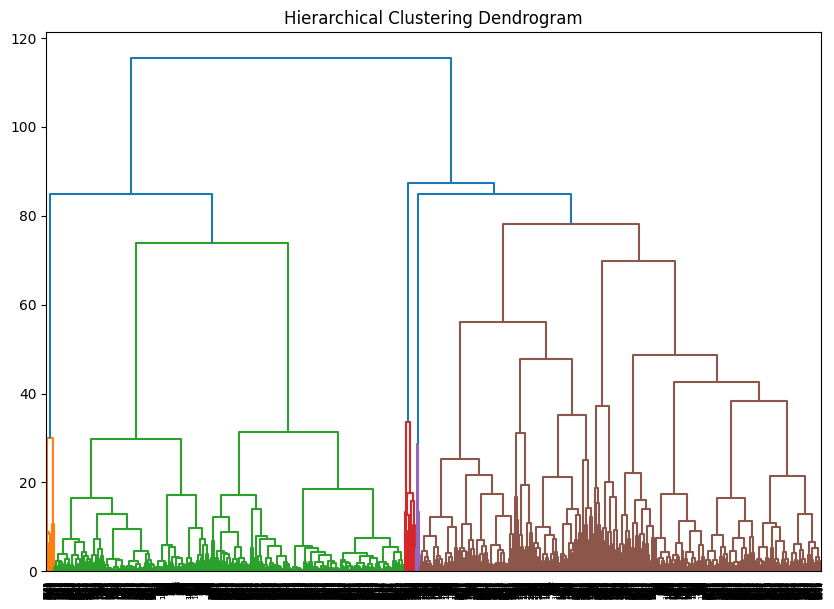

DBSCAN did not form valid clusters for silhouette score.


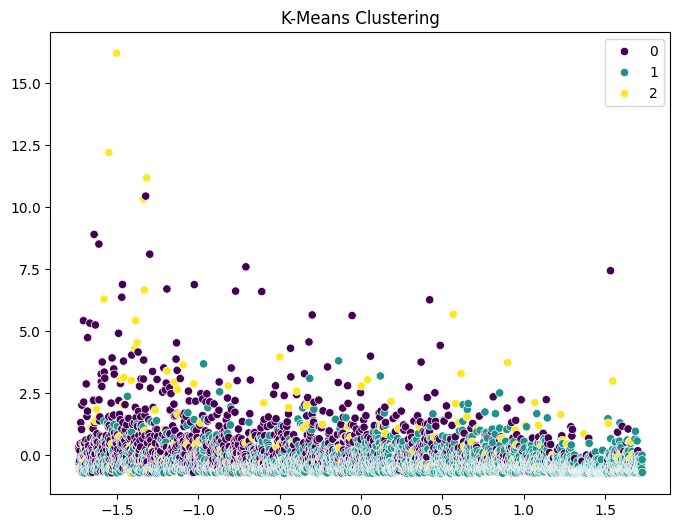

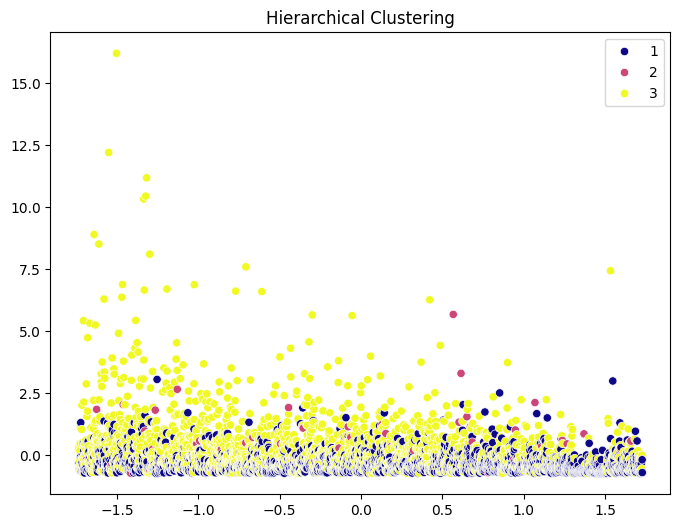

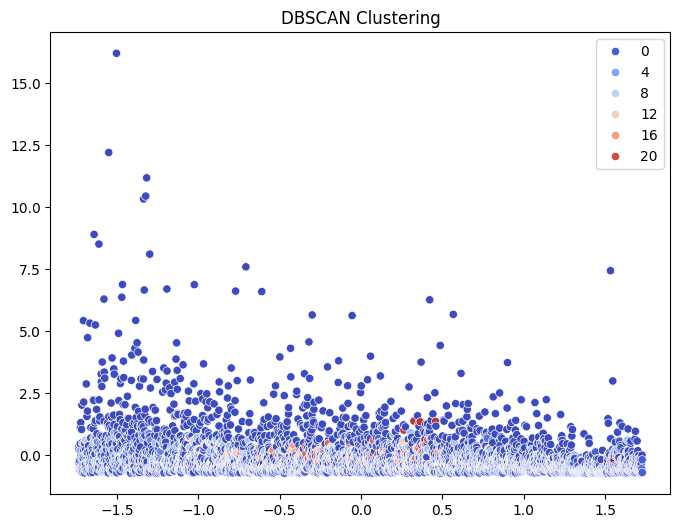

Clustering results saved to clustering_results.xlsx


In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

df = pd.read_excel("/content/EastWestAirlines.xlsx", sheet_name=1, skiprows=9)

df = df.dropna()
df_numeric = df.select_dtypes(include=['float64', 'int64'])

df_numeric.columns = df_numeric.columns.astype(str)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)
inertia = []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_data)
df['KMeans_Cluster'] = kmeans_labels

print("K-Means Silhouette Score:", silhouette_score(scaled_data, kmeans_labels))

linked = linkage(scaled_data, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

hier_labels = fcluster(linked, t=3, criterion='maxclust')
df['Hierarchical_Cluster'] = hier_labels
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)
df['DBSCAN_Cluster'] = dbscan_labels

if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels):
    print("DBSCAN Silhouette Score:", silhouette_score(scaled_data, dbscan_labels))
else:
    print("DBSCAN did not form valid clusters for silhouette score.")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('K-Means Clustering')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=hier_labels, palette='plasma')
plt.title('Hierarchical Clustering')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=dbscan_labels, palette='coolwarm')
plt.title('DBSCAN Clustering')
plt.show()
df.to_excel("clustering_results.xlsx", index=False)
print("Clustering results saved to clustering_results.xlsx")